## Numerical Solution of LWR model:

Lighthill-Whitham-Richards model (commonly used for traffic flow):

\begin{equation}
\frac{\partial q}{\partial x} + \frac{\partial k}{\partial t} = 0
\end{equation}

But $q$ is a function of $k$ (Greenshield model): 
$$
q(k) = k(k_j - k) = k k_j -k^2
$$

Therefore
$$
\frac{\partial k}{\partial t} + \frac{dq}{dk}\frac{\partial k}{\partial x} =0
$$

$$
\frac{d(q(k))}{dk} = 1(k_j - k) + k(-1) = k_j - 2k
$$

And
$$
\frac{\partial k}{\partial t} + (k_j - 2k) \frac{\partial k}{\partial x} = 0
$$

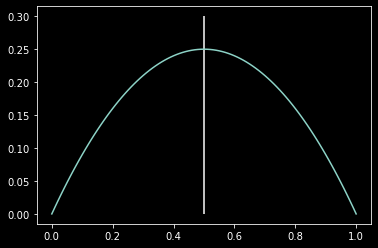

In [1]:
# k can never be higher than kj, which is the jam density.
# Therefore, using k > kj results in instabilities!
def greenshield(k, kj=1.):
    q=k*(kj-k)
    return q

import numpy as np
k=np.arange(0., 1.01, 0.01)
import matplotlib.pyplot as plt
q=greenshield(k)
plt.style.use('dark_background')
plt.plot(k,q)
plt.vlines(0.5, 0, 0.30)

$$
\frac{\partial k}{\partial t} = (2k - k_j) \frac{\partial k}{\partial x}
$$

\begin{equation}
\frac{k(t+\Delta t, x_n) - k(t, x_n)}{\Delta t} =  \left(2k(t, x) - k_j\right) \frac{\partial k}{\partial x}
\end{equation}

\begin{align}
k(t + \Delta t, x_n) =& k(t, x) + \Delta t \left(2k(t, x) - k_j\right) \frac{\partial k}{\partial x}
\end{align}

\begin{align}
\frac{\partial{k}}{\partial x} \approx \frac{k(t, x + \Delta x) - k(t,x - \Delta x)}{2 \Delta x} \\
                               \approx \frac{k(t, x + \Delta x) - k(t, x)}{\Delta x} \\
\end{align}

If I remember correctly the central difference formula is unstable when used with the forward time step, 
but I will check into this.

**Update:** Yes, that's correct.  See Gaddam *et al.*., 2015.  Only the upwind scheme is stable, downwind and central are unstable.  Alternative leapfrog 
or higher order methods are mentioned in this reference.

Discretizing along t_i for i=0,$n_t$ and x_n for n=0, $n_x$.
$k_n^i$ equals the traffic density at time $t_i$ and position $n_i$.

Sampling rates are $\Delta t$ and $\Delta x$, respectively.
$k_j(x)$ is location dependent.  Call it $\kappa_n$.

$$
k_n^{i+1} = k_n^i + \Delta t  (2 k_n^i - \kappa_n) \frac{k_{n+1}^i - k_n^i}{\Delta x}
$$

In a real world scenario, we wouldn't have data at every point along the discretized distance.
This is different from the scenario tested here.  Therefore, the functions needs to be modified
to internally calculate points with the discretization distance needed to fulfill the stability criterion, while outputting predictions only where data is available.

In [2]:
import numpy as np

## Considerations for time and grid step in numerical solution

The CFL condition applies:

\begin{equation}
C = \frac{u \Delta t}{\Delta x} \leq C_\max,
\end{equation}

where $C_\max = 1$.

Using $u$ = 120 km/h and $\Delta t = \frac{1}{12}$ hour, $\Delta x$ needs to be smaller or equal to 10 km to meet the CFL condition:

\begin{equation}
\Delta x = \frac{u \Delta t}{C} = \frac{120 \text{ km/h} \cdot \frac{1}{12} \text{h}}{1.0} = 10 km
\end{equation}

However, the total length of the segment to model, is 12 km, and receivers spacings vary from 100 m to 1 km.  Therefore, $\Delta x$ needs to be 0.1 km or less and the appropriate time step to use is

\begin{equation}
\Delta t = \frac{C}{u} \Delta x = 1 \frac{0.1 \text{ km}}{120 \text{ km/h}} = \frac{1}{1200} \text{h} = 3 s
\end{equation}

It might be easier to work in SI units (seconds and meters instead).  $\Delta x = 100 m$, and $u$ = 33.33 m/s.

As $\Delta t$ = 3 s, and the traffic density is provided once every 5 mins / 300 seconds, one out of 100 timesteps is being output (`tskip = 100`).

In [3]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets

In [4]:
import torch 
import torch.nn as nn

In [5]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="4"
device = torch.device("cpu")
print(device)
import matplotlib.pyplot as plt
from tqdm import tqdm

cpu


In [6]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [183]:
class Neural_LWR_sparse2(nn.Module):
    def __init__(self, nx, dx, dt, kj, xi, tskip, initial='random', boundary='zeros'):
        self.nx = nx
        #xi are the locations along distance where data is available
        self.xi = xi
        self.tskip = tskip
            
        super(Neural_LWR_sparse2, self).__init__()
        if initial == 'random':
            #self.initial = torch.nn.Parameter(torch.rand(nx))
            self.initial = torch.rand(nx)
        elif initial == 'zeros':
            self.initial = torch.zeros(nx, requires_grad=True).double()
            #self.initial[0] = self.boundary[0]
        else:
            #self.initial = torch.nn.Parameter(initial)
            self.initial = torch.tensor(initial)
            
        # influx at upstream border - needs to be known or assumed
        if boundary == 'zeros':
            self.boundary = torch.zeros(nt, requires_grad=True).double()
        else:
            self.boundary = torch.tensor(boundary)
            
        #initial conditions
        #self.k[0] = self.initial
        
        self.kappa=torch.nn.Parameter(kj, requires_grad=True)
        
        self.dx = torch.tensor(dx)
        self.dt = torch.tensor(dt)
        
    def forward(self, tsteps):
        
        nt=len(tsteps)
        self.k=[self.initial]
        
        self.ki=[self.initial[self.xi]]
        ##self.k=torch.zeros((nt,nx), dtype=torch.double)
        #self.k=torch.zeros((nt,nx), requires_grad=True).double()
        #self.k[0:50,0]=self.kappa[0]/2.
        
        for n in range(1,nt):
            tmp1=2*self.k[n-1][1:] - self.kappa[1:]
            #This corresponds to the upwind scheme according to Gaddam et al. (2015).
            tmp2=(self.k[n-1][1:]-self.k[n-1][:-1]) / self.dx
            #tmp1=2*self.k[n-1,1:] - self.kappa[1:]
            #tmp2=(self.k[n-1,1:]-self.k[n-1,:-1]) / self.dx
            #nk=torch.DoubleTensor(nx)
            nk=torch.zeros(nx, requires_grad=True).double()

            nk[0] = self.boundary[n]
            nk[1:]=self.k[n-1][1:] + self.dt*tmp1 * tmp2
            
            #force k to be less or equal kappa
            idx = nk > self.kappa
            nk[idx] = self.kappa[idx]
            
            self.k.append(nk)
            #only output every tskip timesteps
            if (n % self.tskip) == 0:
                self.ki.append(nk[self.xi])
            #self.k[n,1:] = self.k[n-1,1:] + self.dt*tmp1 * tmp2
            #self.k.append(self.k[n][1:] + self.dt*(2*self.k[n][1:] - self.kappa[1:]) * \
            #    (self.k[n][1:]-self.k[n][:-1]) / self.dx)
            
        return torch.stack(self.ki)
        #return self.k

In [184]:
y_exact=torch.load("5S_191111_torch.pt")
#y_exact=y_exact[0:5,:]
print(y_exact.shape)

torch.Size([71, 31])


In [185]:
y_exact.mean().mean()

tensor(0.0868, dtype=torch.float64)

In [205]:
import numpy as np
#nx=350  # 
nx=120
#kj needs to be larger than k for the solution to be stable
kj = np.ones((nx,), dtype=float) * 1.00

dx=300.
dt=10
#need an output every 5 mins (300 s), so tskip = 3 with dt = 3s
#tskip=100
tskip=30
#nt=int(3600*6/6 - 50)
#nt=7099 #6 hours (times 3600 s/hour divided by dt=3s)
nto=(y_exact.shape[0]+1)
#nt=int(3600*nto/12/6/dt - tskip)
dtobs=300
nt=int((dtobs*nto)/dt - tskip)
print(dt,nt)

#assert int(nt/tskip) == nto

10 2130


In [206]:
#import pandas as pd
import json

station_pos_idx=json.load(open("5S_station_pos_idx_dx=%04dm.json" % int(dx), "rb"))
#station_pos_idx=pd.read_json("station_pos_idx.json")
xi=list(station_pos_idx.values())

xi0=xi[0]
for p in range(len(xi)):
    xi[p] = xi[p] - xi0

#shift xi's such that model starts at first receiver
#(because observed data at this receiver is input at upstream model end)
print(xi)
#xi=xi-xi[0]
#xi

[0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]


The exact solution is provided in cars / km.  However, I changed the units from km and hours to meters and seconds.  Therefore, the density should be divided by 1000.

**Update:** Not needed, `avg_occupancy` is already given in cars/meters (check this.  They might be using miles).

In [207]:
steps=torch.tensor(np.linspace(0, nt, nt), requires_grad=True).float()

Defining the initial values of the traffic density in the model.  They need to be defined on every point on the computational grid, not just at those positions where there is data.  I am interpolating them between the sensors, and extrapolating using initial values on the end sensors.

In [208]:
from scipy.interpolate import interp1d
print(xi)
IM=interp1d(np.array(xi)*dx, y_exact[0,:].numpy(), bounds_error=False, 
            fill_value=(y_exact[0,0], y_exact[0,-1]))

[0, 4, 12, 22, 32, 39, 46, 50, 54, 57, 59, 63, 66, 69, 71, 74, 76, 81, 84, 86, 89, 91, 95, 96, 98, 100, 102, 105, 108, 110, 112]


In [209]:
x=np.linspace(0, (nx-1)*dx, nx)

k_initial=IM(x)
print(k_initial.max())

0.1965


The boundary condition at the upstream end also need to be interpolated:

71 71
0.08789670145054401


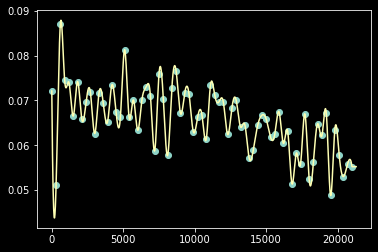

In [210]:
ti=np.arange(0, (nt-1)*dt, tskip*dt )
print(len(ti), y_exact.shape[0])
t=np.linspace(0, (nt-1)*dt, nt)
#print(len(ti), len(y_exact))
#print(t)
IMb=interp1d(np.array(ti), y_exact[:,0].numpy(), bounds_error=False,
             fill_value=(y_exact[0,0], y_exact[-1,0]),
             kind='cubic')
k_boundary=IMb(t)
k_boundary.shape
print(k_boundary.max())

fig2,ax2=plt.subplots()
ax2.plot(ti, y_exact[:,0], marker='o', linewidth=0)
ax2.plot(t, k_boundary)

In [234]:
tdnu = Neural_LWR_sparse2(nx, dx, dt, torch.nn.Parameter(torch.tensor(kj)), xi, tskip, 
                          initial=k_initial, boundary=k_boundary)

optimizer = torch.optim.Adam(tdnu.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95) #0.95
#torch.optim.lr_scheduler.StepLR?

<ipython-input-183-17c7936fa25f>:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if initial == 'random':
<ipython-input-183-17c7936fa25f>:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif initial == 'zeros':
<ipython-input-183-17c7936fa25f>:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if boundary == 'zeros':


In [235]:
num_epochs = 150
loss_fun = torch.nn.MSELoss()
min_loss = 10

In [236]:
y_approx = tdnu(steps)
print(y_exact.shape, y_approx.shape)

torch.Size([71, 31]) torch.Size([71, 31])


tensor([0.0552, 0.0584, 0.0599, 0.0648, 0.0682, 0.0690, 0.0696, 0.0704, 0.0722,
        0.0743, 0.0758, 0.0790, 0.0808, 0.0819, 0.0821, 0.0820, 0.0817, 0.0803,
        0.0794, 0.0787, 0.0774, 0.0763, 0.0736, 0.0728, 0.0712, 0.0694, 0.0677,
        0.0655, 0.0642, 0.0641, 0.0647], dtype=torch.float64,
       grad_fn=<SelectBackward>)
tensor([0.0552, 0.0894, 0.0688, 0.0776, 0.0586, 0.0535, 0.0490, 0.0558, 0.0469,
        0.0478, 0.0502, 0.0689, 0.0611, 0.0715, 0.0604, 0.0625, 0.0662, 0.0605,
        0.0630, 0.0605, 0.1152, 0.0542, 0.0610, 0.0571, 0.0675, 0.0660, 0.0556,
        0.0857, 0.0873, 0.0664, 0.0797], dtype=torch.float64)
0.074


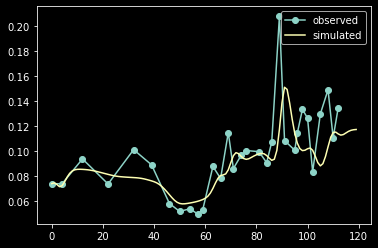

In [237]:
#y_approx
print(y_approx[-1])
print(y_exact[-1])
fig,ax=plt.subplots()
tp=4
ax.plot(xi, y_exact[tp].detach(), label='observed', marker='o')
#ax.plot(xi, y_approx[0].detach(), label='trained')
ax.plot(tdnu.k[tp*tskip].detach(), label='simulated')
print(k_boundary[tp*tskip])
ax.legend()

In [238]:
print(len(y_approx), len(y_exact))
loss=loss_fun(y_approx, y_exact)
#torch.cat(tdn.k, dim=1).shape
#torch.cat([torch.tensor(p) for p in tdn.k], dim=1).shape
print(loss)

71 71
tensor(0.0008, dtype=torch.float64, grad_fn=<MseLossBackward>)


In [239]:
tqdm_epochs = tqdm(range(num_epochs))
for e in tqdm_epochs:
    y_approx = tdnu(steps)
    loss = loss_fun(y_approx, y_exact)
    if loss.item() < min_loss:
        best_model_lwr = tdnu
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

100%|██████████| 150/150 [02:06<00:00,  1.19it/s, loss=0.000545]


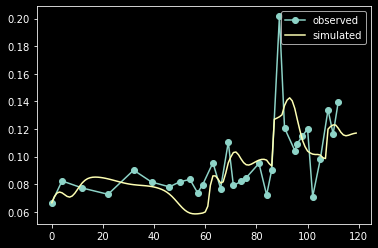

In [273]:
tp=5
#print(y_approx[tp])
#print(y_exact[tp])
fig3,ax3=plt.subplots()
ax3.plot(xi, y_exact[tp].detach(), label='observed', marker='o')
ax3.plot(tdnu.k[tp*tskip].detach(), label='simulated')
#print(k_boundary[tp*tskip])
ax3.legend()
#ax3.set_ylim(0, 0.3)

In [274]:
85*0.3

25.5

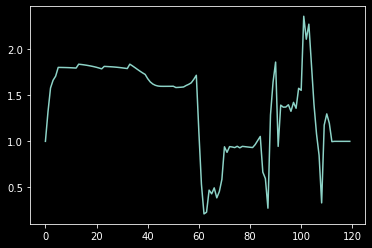

In [248]:
fig4,ax4=plt.subplots()
ax4.plot(tdnu.kappa.detach())

In [ ]:
y_exact.shape

In [ ]:
#tdn.k[500]

In [ ]:
#tdnu.k[500]

In [ ]:
from matplotlib.pyplot import get_cmap
cm=get_cmap('BrBG')
cm(0.5, alpha=None)

In [ ]:
#ti=500
#fig2 = make_subplots(rows=1, cols=1, subplot_titles=["Density","Flow","Velocity"],  shared_xaxes=True)
#trace1=go.Scatter(y=tdn.k[ti].detach(), mode='lines', name='synthetic', line=dict(width=1))
#trace2=go.Scatter(y=tdnu.k[ti].detach(), mode='lines', name='training', line=dict(width=1,dash='dash'))
#fig2.add_trace(trace1, row=1, col=1)
#fig2.add_trace(trace2, row=1, col=1)

In [ ]:
y_exact.shape

In [ ]:
fig2,ax2=plt.subplots(figsize=(12,4))

for p in range(len(xi)):
    clr=cm(p/len(xi))
    ax2.plot(y_exact[:,p].detach(), label=xi[p], color=clr, linestyle='solid', linewidth=2)
    ax2.plot(y_approx[:,p].detach(), label=xi[p], color='white', linestyle='dashed')
ax2.legend()

In [ ]:
"""
fig2 = make_subplots(rows=1, cols=1, subplot_titles=["Density","Flow","Velocity"],  shared_xaxes=True)

for n,ti in enumerate(range(0,nt+100,100)):
    clr=cm(ti/nt)
    clrs="rgb(%d,%d,%d)" % (clr[0]*255, clr[1]*255, clr[2]*255)
    #print(clrs)
    fig2.add_trace(go.Scatter(y=tdn.k[ti].detach(), mode='lines', name=str(ti), 
                             legendgroup=ti, showlegend=True,
                             line=dict(width=2,color=clrs)))
    fig2.add_trace(go.Scatter(y=tdnu.k[ti].detach(), mode='lines', name=str(ti), 
                             legendgroup=ti, showlegend=True,
                             line=dict(width=1,color="black",dash='dot')))
fig2.show()
""";

In [ ]:
fig3=make_subplots()
#fig3.add_trace(go.Scatter(y=kj, name='$\\text{True} \ k_j$'))
#fig3.add_trace(go.Scatter(y=tdnu.kappa.detach(), name='$\\text{Estimated} \ k_j$', line=dict(dash='dash')))
fig3.add_trace(go.Scatter(y=kj, name='True'))
fig3.add_trace(go.Scatter(y=tdnu.kappa.detach(), name='Estimated', line=dict(dash='dash')))
fig3.add_trace(go.Scatter(x=xi, y=np.ones(len(xi))*0.05))
fig3.update_yaxes(title="k_j")
fig3.update_xaxes(title="Distance")

In [ ]:
go.Scatter?